[Reference](https://medium.com/ai-techsystems/predictive-maintainance-using-lstm-application-based-on-iiot-a27b1f9f2368)

In [33]:
import tensorflow.keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm.keras import TqdmCallback

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [45]:
# define path to save model
model_path = 'predictive_maintenance_model.h5'

In [46]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/dark/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

In [47]:
# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/dark/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [48]:
# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/dark/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [38]:
# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/dark/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [49]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [50]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

In [51]:
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [52]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [53]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

In [54]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [55]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [56]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())
           
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

In [57]:
seq_array.shape

(15631, 50, 25)

In [58]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

In [59]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [60]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           50400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       tensorflow.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0),
                       TqdmCallback(verbose=2)]
          )


Epoch 1/100


75/75 - 21s - loss: 0.2949 - accuracy: 0.8716 - val_loss: 0.1606 - val_accuracy: 0.9309
Epoch 2/100



75/75 - 17s - loss: 0.1103 - accuracy: 0.9561 - val_loss: 0.0799 - val_accuracy: 0.9616
Epoch 3/100



75/75 - 17s - loss: 0.0801 - accuracy: 0.9674 - val_loss: 0.0667 - val_accuracy: 0.9693
Epoch 4/100



75/75 - 17s - loss: 0.0752 - accuracy: 0.9681 - val_loss: 0.0426 - val_accuracy: 0.9872
Epoch 5/100



75/75 - 17s - loss: 0.0663 - accuracy: 0.9729 - val_loss: 0.0386 - val_accuracy: 0.9859
Epoch 6/100



75/75 - 17s - loss: 0.0574 - accuracy: 0.9753 - val_loss: 0.0551 - val_accuracy: 0.9744
Epoch 7/100



75/75 - 17s - loss: 0.0587 - accuracy: 0.9758 - val_loss: 0.0323 - val_accuracy: 0.9859
Epoch 8/100



75/75 - 17s - loss: 0.0638 - accuracy: 0.9727 - val_loss: 0.0418 - val_accuracy: 0.9821
Epoch 9/100



75/75 - 17s - loss: 0.0572 - accuracy: 0.9758 - val_loss: 0.0281 - val_accuracy: 0.9872
Epoch 10/100



75/75 - 17s - loss: 0.0519 - accuracy: 0.9780 - val_loss: 0.0331 - val_accuracy: 0.9834
Epoch 11/100



75/75 - 17s - loss: 0.0542 - accuracy: 0.9760 - val_loss: 0.0755 - val_accuracy: 0.9655
Epoch 12/100



75/75 - 17s - loss: 0.0478 - accuracy: 0.9797 - val_loss: 0.0835 - val_accuracy: 0.9680
Epoch 13/100



75/75 - 17s - loss: 0.0578 - accuracy: 0.9755 - val_loss: 0.0376 - val_accuracy: 0.9847
Epoch 14/100



75/75 - 19s - loss: 0.0478 - accuracy: 0.9800 - val_loss: 0.0735 - val_accuracy: 0.9655
Epoch 15/100



75/75 - 17s - loss: 0.0543 - accuracy: 0.9778 - val_loss: 0.0264 - val_accuracy: 0.9885
Epoch 16/100



75/75 - 17s - loss: 0.0468 - accuracy: 0.9799 - val_loss: 0.0358 - val_accuracy: 0.9885
Epoch 17/100



75/75 - 17s - loss: 0.0486 - accuracy: 0.9800 - val_loss: 0.0355 - val_accuracy: 0.9821
Epoch 18/100



75/75 - 17s - loss: 0.0465 - accuracy: 0.9803 - val_loss: 0.0354 - val_accuracy: 0.9808
Epoch 19/100



75/75 - 17s - loss: 0.0465 - accuracy: 0.9793 - val_loss: 0.0561 - val_accuracy: 0.9783
Epoch 20/100



75/75 - 17s - loss: 0.0442 - accuracy: 0.9819 - val_loss: 0.0554 - val_accuracy: 0.9795
Epoch 21/100



75/75 - 17s - loss: 0.0409 - accuracy: 0.9830 - val_loss: 0.0193 - val_accuracy: 0.9923
Epoch 22/100



75/75 - 17s - loss: 0.0397 - accuracy: 0.9832 - val_loss: 0.0615 - val_accuracy: 0.9770
Epoch 23/100



75/75 - 17s - loss: 0.0414 - accuracy: 0.9825 - val_loss: 0.0350 - val_accuracy: 0.9795
Epoch 24/100



75/75 - 17s - loss: 0.0397 - accuracy: 0.9831 - val_loss: 0.0284 - val_accuracy: 0.9847
Epoch 25/100



75/75 - 17s - loss: 0.0380 - accuracy: 0.9836 - val_loss: 0.0433 - val_accuracy: 0.9821
Epoch 26/100



75/75 - 17s - loss: 0.0392 - accuracy: 0.9844 - val_loss: 0.0316 - val_accuracy: 0.9885
Epoch 27/100



75/75 - 17s - loss: 0.0421 - accuracy: 0.9820 - val_loss: 0.0436 - val_accuracy: 0.9757
Epoch 28/100



75/75 - 17s - loss: 0.0363 - accuracy: 0.9846 - val_loss: 0.0327 - val_accuracy: 0.9885
Epoch 29/100



75/75 - 17s - loss: 0.0378 - accuracy: 0.9829 - val_loss: 0.0492 - val_accuracy: 0.9783
Epoch 30/100



75/75 - 17s - loss: 0.0403 - accuracy: 0.9826 - val_loss: 0.0337 - val_accuracy: 0.9872
Epoch 31/100



75/75 - 17s - loss: 0.0403 - accuracy: 0.9817 - val_loss: 0.0582 - val_accuracy: 0.9744




In [63]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


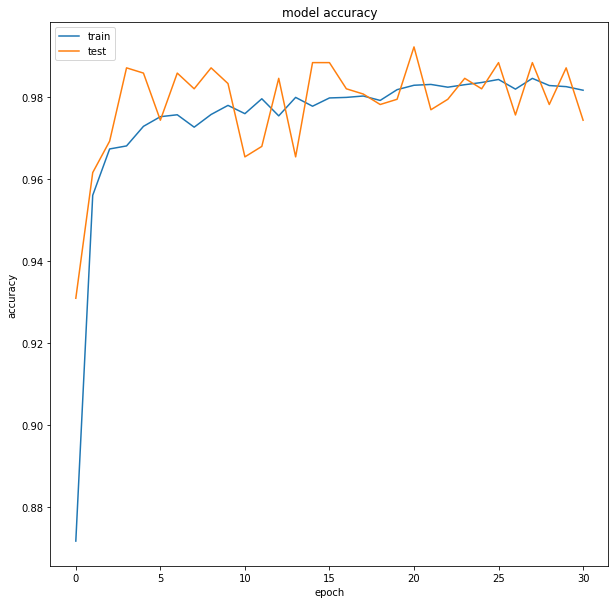

In [64]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

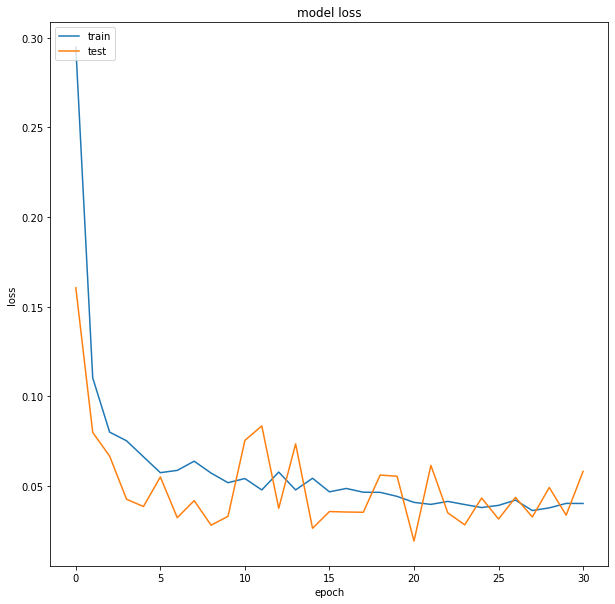

In [65]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

In [66]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 7s 84ms/step - loss: 0.0517 - accuracy: 0.9794
Accurracy: 0.9793999195098877


In [67]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


79/79 [==============================] - 7s 84ms/step


In [68]:
test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

In [69]:
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12238   293]
 [   29  3071]]


In [70]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9129013079667063 
 recall =  0.9906451612903225


In [71]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last)
print(seq_array_test_last.shape)

seq_array_test_last
[[[0.3505747  0.8333333  0.         ... 0.         0.4728682  0.45457056]
  [0.39655173 0.5833333  0.         ... 0.         0.6511628  0.5608948 ]
  [0.5114943  0.25       0.         ... 0.         0.6356589  0.4975145 ]
  ...
  [0.43678162 0.75       0.         ... 0.         0.41860464 0.4710025 ]
  [0.5804598  0.6666667  0.         ... 0.         0.3255814  0.45954156]
  [0.40804598 0.8333333  0.         ... 0.         0.6124031  0.52444077]]

 [[0.55172414 0.25       0.         ... 0.         0.5503876  0.6974593 ]
  [0.39655173 0.5833333  0.         ... 0.         0.37209302 0.59748685]
  [0.5344828  0.16666667 0.         ... 0.         0.51937985 0.602596  ]
  ...
  [0.43103448 0.33333334 0.         ... 0.         0.56589144 0.49461475]
  [0.33908045 0.25       0.         ... 0.         0.4108527  0.5223695 ]
  [0.5689655  0.8333333  0.         ... 0.         0.34108528 0.5024855 ]]

 [[0.7356322  0.25       0.         ... 0.         0.53488374 0.6023198 ]
  

In [72]:
# Similarly, we pick the labels

# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
print("y_mask")
print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

y_mask
[False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
(93, 1)
label_array_test_last
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 

In [73]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

In [74]:
# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accuracy: {}'.format(scores_test[1]))

3/3 - 1s - loss: 0.0540 - accuracy: 0.9677
Accuracy: 0.9677419066429138


In [75]:
# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [76]:
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

In [77]:
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 2 23]]


In [78]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9583333333333334 
 Recall:  0.92 
 F1-score: 0.9387755102040817


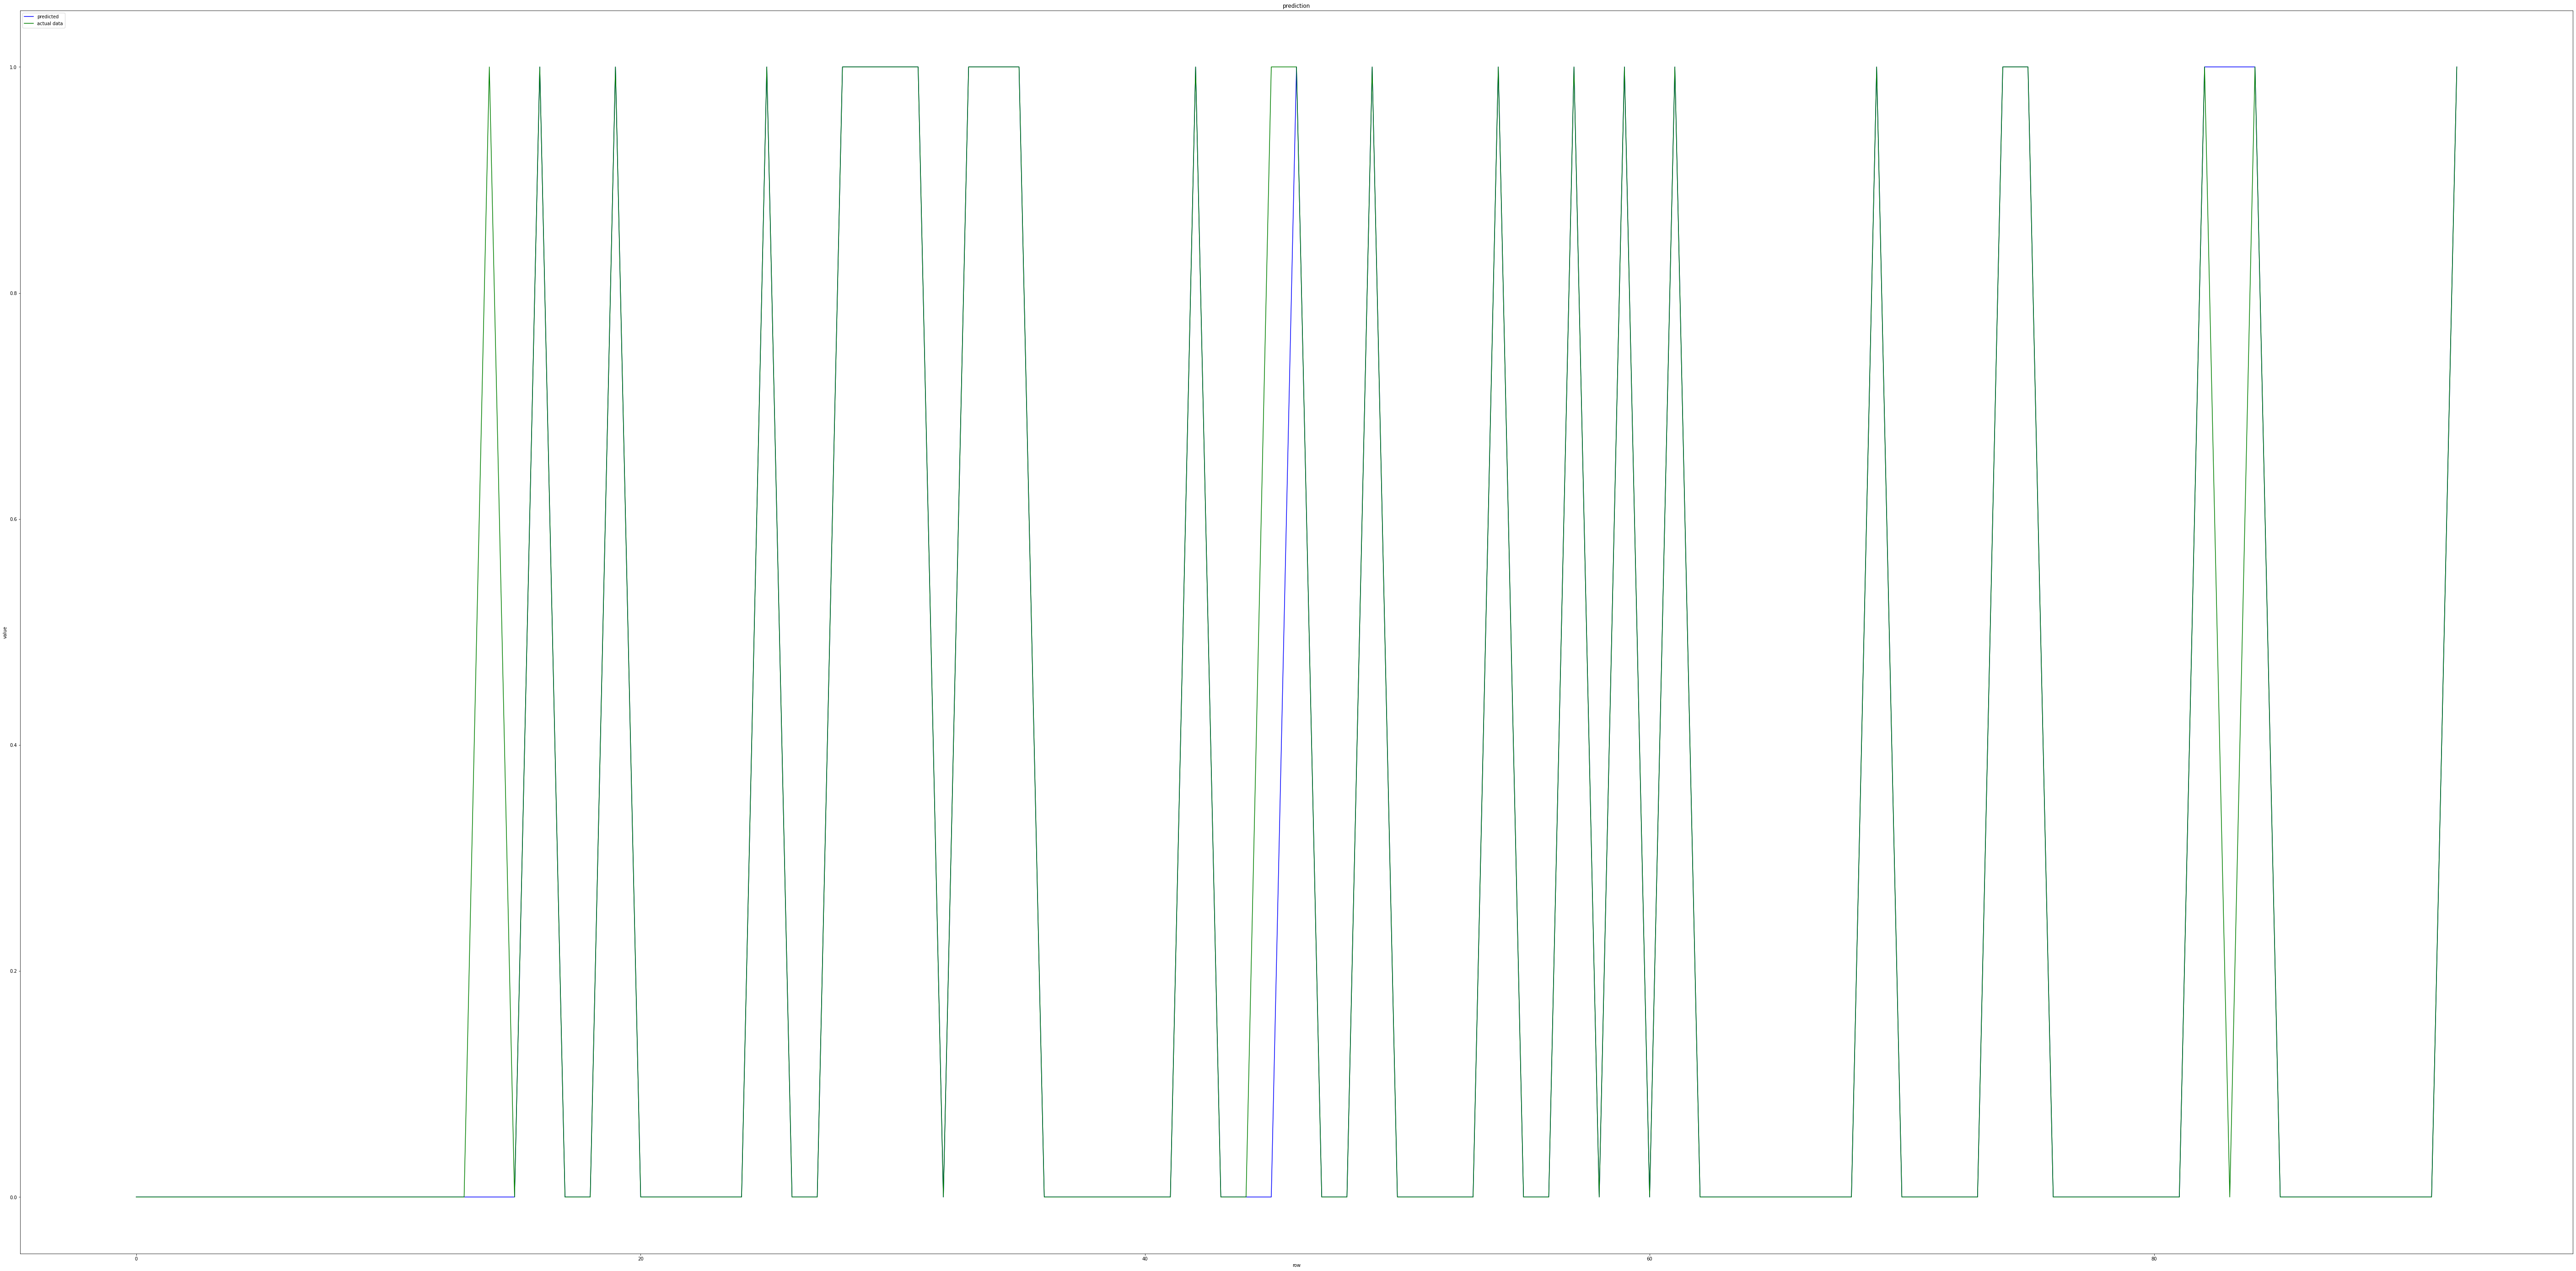

In [79]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

In [80]:
# !deepCC predictive_maintenance_model.h5